# Notebook to perform sentiment analysis and topic modelling for Mentaiya. Please read the text below.

# Important Information
This notebook was ran on Google Colab Pro (not drive mounted). To replicate this notebook:

<ol>
    <li> Import notebook to colab</li>
    <li> Import StickNBowls's combined reviews dataset. Dataset can be found in repository: <b>/data/competitors/StickNBowls_reviews_combined.csv</b></li>
    <li> Change runtime to GPU</li>
    <li> Install dependencies (run code block below. You may be asked to restart runtime after installing. If you do so, please ensure runtime is GPU again.</li>
</ol>

# Expected directory
In google colab, your directory should now consist of one folder and two files:
<ol>
    <li>sample_data folder: Default folder from Google Colab</li>
    <li>StickNBowls_reviews_combined.csv: Dataset comprising Mentaiya's reviews from all data sources</li>
</ol>

In [3]:
!pip install bertopic
!pip install datasets transformers[sentencepiece]

In [4]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import string
import re
import string

from PIL import Image
import os
from os import path
import csv

from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Helper Functions

In [6]:
# Function to create a dictionary with word counts from dataframe 
def count_words_from_dataframe(df):
    result_dict = {}
    # iterate rows of dataframe 
    for index, row in df.iterrows():
        text = row["cleaned_reviews"]
        
        # this will split a sentence into words 
        tokens = text.split()
        
        # iterate each word 
        for i in range(0, len(tokens)):
            token = tokens[i].rstrip()
            token=token.strip()
            try:
                result_dict[token] += 1
            except KeyError:
                result_dict[token] = 1
                    
    return result_dict

In [7]:
# Function to create Word Cloud
def makeImage(termDict):
    
    wc = WordCloud(max_font_size=150, width=1280, height=720, background_color="white")    

    # generate word cloud using frequencies!
    wc.generate_from_frequencies(termDict)
    
    # show the figure
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

In [8]:
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\n','',text) #remove \n which act as extra lines in reviews
    return text

In [9]:
# Variable 'stop' set to list of english stopwords from nltk library
stop = stopwords.words('english')
stop.extend(['ngl','lol','thats','theyre','tbh','idk','rall','theres','youre','yall','dont','aint','ive','arent','havent','wtf','thatll','omg','theyd','woah','fucking','wouldve','shit','wouldve','werent','repost','deleted','heres','wouldnt','fuck','cant','haha'])

def clean_text_round2(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

In [10]:
def read_word_count_file(file_path):
    with open(file_path, mode='r', encoding="latin1") as infile:
        reader = csv.reader(infile)
        counts = {}
        for row in reader:
            if len(row) >0 :
                counts[row[0]] = float(row[1])
        return counts

# Get Data

In [12]:
comments_df = pd.read_csv("StickNBowls_reviews_combined.csv", encoding="unicode-escape", header=None)
comments_df = comments_df.rename(columns={0: "Reviews"})

In [14]:
comments_df.head()

,Reviews
0,"Bought the Mentaiko Salmon Bowl, Unagi Toji Do..."
1,"Was looking forward to try this, but got super..."
2,Ordered the lok lok and requested to go with t...
3,Have been wanting to try and finally I did. My...
4,Amazing find at a coffee shop. They serve diff...


# Data Cleaning

In [15]:
comments_df["clean_text_1"]=comments_df['Reviews'].apply(clean_text_round1)
comments_df

,Reviews,clean_text_1
0,"Bought the Mentaiko Salmon Bowl, Unagi Toji Do...",bought the mentaiko salmon bowl unagi toji don...
1,"Was looking forward to try this, but got super...",was looking forward to try this but got super ...
2,Ordered the lok lok and requested to go with t...,ordered the lok lok and requested to go with t...
3,Have been wanting to try and finally I did. My...,have been wanting to try and finally i did my ...
4,Amazing find at a coffee shop. They serve diff...,amazing find at a coffee shop they serve diffe...
5,"Value for money. On first look, the bowls look...",value for money on first look the bowls look s...
6,Food was OK but I'm totally disappointed with ...,food was ok but im totally disappointed with t...
7,Had the beef bowl and unagi toji bowl recently...,had the beef bowl and unagi toji bowl recently...
8,Ordered mentaiko chicken bowl and the chicken ...,ordered mentaiko chicken bowl and the chicken ...
9,Ordered the garlic pork belly rice bowl and ch...,ordered the garlic pork belly rice bowl and ch...


In [21]:
comments_df['clean_text_2']=comments_df['clean_text_1'].apply(clean_text_round2)
comments_df.head()

,Reviews,clean_text_1,clean_text_2
0,"Bought the Mentaiko Salmon Bowl, Unagi Toji Do...",bought the mentaiko salmon bowl unagi toji don...,bought mentaiko salmon bowl unagi toji mentaik...
1,"Was looking forward to try this, but got super...",was looking forward to try this but got super ...,looking forward try got super shocked outrageo...
2,Ordered the lok lok and requested to go with t...,ordered the lok lok and requested to go with t...,ordered lok lok requested go rice technically ...
3,Have been wanting to try and finally I did. My...,have been wanting to try and finally i did my ...,wanting try finally sons loved salmon much gar...
4,Amazing find at a coffee shop. They serve diff...,amazing find at a coffee shop they serve diffe...,amazing find coffee shop serve different type ...


In [17]:
cleaned_df = pd.DataFrame()
cleaned_df["cleaned_reviews"] = comments_df["clean_text_2"]
cleaned_df.head()

,cleaned_reviews
0,bought mentaiko salmon bowl unagi toji mentaik...
1,looking forward try got super shocked outrageo...
2,ordered lok lok requested go rice technically ...
3,wanting try finally sons loved salmon much gar...
4,amazing find coffee shop serve different type ...


In [18]:
# Get word frequency
result = count_words_from_dataframe(cleaned_df)

# sorting the words based on their frequency
sorted_dic = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

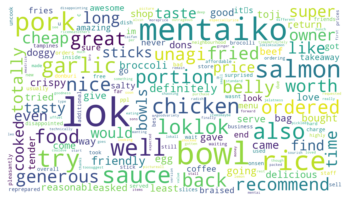

In [19]:
makeImage(sorted_dic)

In [23]:
reviews_list = cleaned_df['cleaned_reviews'].tolist()

In [24]:
reviews_list[:5]

['bought mentaiko salmon bowl unagi toji mentaiko fries lok lokall tasty lok lok sticks deep fried version crispy even though takeaway salmon unagi portion good mentaiko fries also remain crispy timedefinitely purchase',
 'looking forward try got super shocked outrageous shaoxing braised pork bowl expected egg per picture menu got meatrice couldve gotten caifan stall w ricemeatothers going go back',
 'ordered lok lok requested go rice technically lok lok rice bowl see pictureall items well fried goes well sauce broccoli well fried especiallyrice well cooked toosuggest something sourish offset jelatness fried itemsmaybe lemon sauce pickled radish ginger would goodvariety lok lok moreprice reasonable lok lok',
 'wanting try finally sons loved salmon much garlic pork belly awesome going back try rest menu im sure never disappointing leo alvin thanks bunch bro soon',
 'amazing find coffee shop serve different type bowls lokloksalmon mentai bowl good coffee shop standard lok lok fried well'

# Sentiment Analysis with HuggingFace

In [25]:
# Load the "sentiment prediction" model.
classifier = pipeline("sentiment-analysis", device = 0)

# input: sentence, output: sentiment label and score
sentiment_list= classifier(reviews_list)
zipped_list=[]
for i in range(len(reviews_list)):
    zipped=[reviews_list[i],sentiment_list[i]['label'],sentiment_list[i]['score']]
    zipped_list.append(zipped)

df_sentiment=pd.DataFrame(zipped_list, columns=['review','sentiment','sentiment score'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [26]:
df_sentiment.head()

,review,sentiment,sentiment score
0,bought mentaiko salmon bowl unagi toji mentaik...,POSITIVE,0.731990
1,looking forward try got super shocked outrageo...,NEGATIVE,0.993320
2,ordered lok lok requested go rice technically ...,NEGATIVE,0.956964
3,wanting try finally sons loved salmon much gar...,POSITIVE,0.998041
4,amazing find coffee shop serve different type ...,POSITIVE,0.994421


In [27]:
positive_review = df_sentiment[df_sentiment['sentiment'] == 'POSITIVE']
positive_review.head()

,review,sentiment,sentiment score
0,bought mentaiko salmon bowl unagi toji mentaik...,POSITIVE,0.731990
3,wanting try finally sons loved salmon much gar...,POSITIVE,0.998041
4,amazing find coffee shop serve different type ...,POSITIVE,0.994421
9,ordered garlic pork belly rice bowl chose spic...,POSITIVE,0.992137
10,lok lok tasty price reasonablestaff friendly w...,POSITIVE,0.949912


In [28]:
positive_review['sentiment score'].mean()

0.9593215100467205

In [29]:
negative_review = df_sentiment[df_sentiment['sentiment'] == 'NEGATIVE']
negative_review.head()

,review,sentiment,sentiment score
1,looking forward try got super shocked outrageo...,NEGATIVE,0.993320
2,ordered lok lok requested go rice technically ...,NEGATIVE,0.956964
5,value money first look bowls look small its r...,NEGATIVE,0.902478
6,food ok im totally disappointed takeaway nonse...,NEGATIVE,0.994790
7,beef bowl unagi toji bowl recently beef slices...,NEGATIVE,0.996650


In [30]:
negative_review['sentiment score'].mean()

0.96031743950314

In [31]:
df_sentiment['sentiment'].value_counts()

NEGATIVE    18
POSITIVE    16
Name: sentiment, dtype: int64

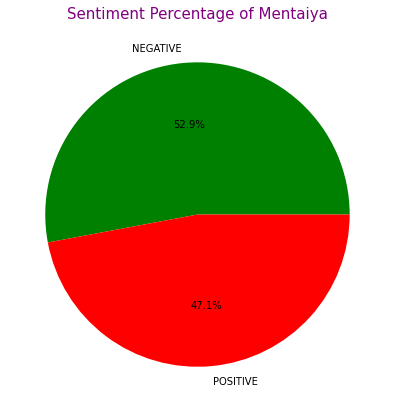

<Figure size 432x288 with 0 Axes>

In [32]:
df = df_sentiment['sentiment'].value_counts()
#pie chart
df.dropna(inplace = True)
labels =df.index
colors = ['green','red']
explode = [0,0]
sizes = df.values

# visual
plt.figure(figsize = (7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Sentiment Percentage of Mentaiya",color = 'purple',fontsize = 15)
fig1 = plt.gcf()
plt.show()
plt.draw()

In [33]:
positive_review_list=positive_review['review'].tolist()
negative_review_list=negative_review['review'].tolist()

# Topic Modelling

In [34]:
positive_review_list[0]

'bought mentaiko salmon bowl unagi toji mentaiko fries lok lokall tasty lok lok sticks deep fried version crispy even though takeaway salmon unagi portion good mentaiko fries also remain crispy timedefinitely purchase'

## For Positive Reviews

In [35]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(positive_review_list)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2022-04-11 12:42:23,693 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-11 12:42:33,117 - BERTopic - Reduced dimensionality with UMAP
2022-04-11 12:42:33,131 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [36]:
freq = topic_model.get_topic_info(); freq.head(20)

,Topic,Count,Name
0,-1,16,-1_lok_mentaiko_salmon_great


### We do not have sufficient data to form meaningful clusteres with topic modelling. We will proceed with wordclouds to identify key topics.

In [39]:
positive_review["cleaned_reviews"] = positive_review["review"]
positive_review = positive_review[["cleaned_reviews"]]
positive_review.head()

,cleaned_reviews
0,bought mentaiko salmon bowl unagi toji mentaik...
3,wanting try finally sons loved salmon much gar...
4,amazing find coffee shop serve different type ...
9,ordered garlic pork belly rice bowl chose spic...
10,lok lok tasty price reasonablestaff friendly w...


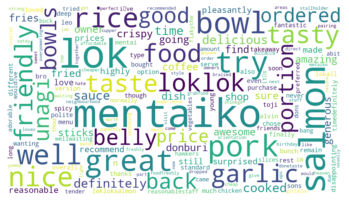

In [41]:
result = count_words_from_dataframe(positive_review)
makeImage(result)

## Negative Reviews

In [42]:
negative_review["cleaned_reviews"] = negative_review["review"]
negative_review = negative_review[["cleaned_reviews"]]
negative_review.head()

,cleaned_reviews
1,looking forward try got super shocked outrageo...
2,ordered lok lok requested go rice technically ...
5,value money first look bowls look small its r...
6,food ok im totally disappointed takeaway nonse...
7,beef bowl unagi toji bowl recently beef slices...


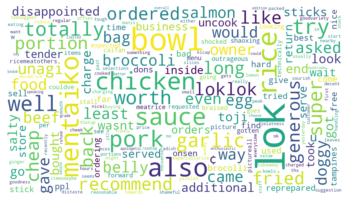

In [44]:
result = count_words_from_dataframe(negative_review)
makeImage(result)